In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import xgboost
import plotly.express as px
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, precision_score, recall_score
import warnings
from plotly.subplots import make_subplots
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

In [2]:
embeddings = pd.read_csv("./data/embeddings.csv")
feat_importance = pd.read_csv("./data/feat_importance.csv")

In [3]:
datasets = ["BZR", "NCI1", "MUTAG", "PROTEINS", "IMDB"]
fixed_cols = ["graph_id", "graph_label", "dataset", "feat_len"]

In [4]:

emb_data = pd.DataFrame()
for dataset in datasets:
    df = embeddings[embeddings["dataset"] == dataset].copy(deep=True)
    dfm = pd.DataFrame()
    for feat_len in df["feat_len"].unique().tolist():
        tmp = df[df["feat_len"] == feat_len].copy(deep=True)
        col_rename = {}
        for col in tmp.columns:
            if col not in fixed_cols:
                col_rename[col] = col +"_"+ str(feat_len-1)
        tmp.rename(columns=col_rename, inplace=True)
        tmp = tmp.drop('feat_len', axis=1)
        tmp = tmp.drop('dataset', axis=1)
        if dfm.empty:
            dfm = tmp.copy(deep=True)
        else:
            dfm = dfm.merge(tmp, on=["graph_id", "graph_label"])
    dfm["dataset"] = dataset        
    if emb_data.empty:
        emb_data = dfm.copy(deep=True)
    else:
        emb_data = pd.concat([emb_data, dfm])

In [5]:
emb_data.head(2)

,graph_id,graph_label,basic_expansion_0,self_walk_0,page_rank_0,degree_centrality_0,closeness_centrality_0,load_centrality_0,eigenvector_centrality_0,lsme_0,...,lsme_2,basic_expansion_3,self_walk_3,page_rank_3,degree_centrality_3,closeness_centrality_3,load_centrality_3,eigenvector_centrality_3,lsme_3,dataset
0,0,-1,1.946408e-09,-0.021841,0.216180,0.202306,0.289911,0.026240,0.199050,-0.070985,...,-0.009453,-0.210577,-0.203792,0.308946,0.291383,-0.376381,-0.196976,-0.286197,-0.149529,BZR
1,1,-1,4.386578e-09,-0.044379,0.097098,0.079057,0.198728,-0.028358,0.110442,0.012324,...,-0.098743,0.004913,-0.210504,0.228915,0.200574,-0.279066,-0.166603,-0.232289,0.101702,BZR


In [8]:
def build_models(data, dataset, feat_imp):

    feat_imp_df = feat_imp[feat_imp["dataset"] == dataset].copy(deep=True)
    data_df = data[data["dataset"] == dataset].copy(deep=True)

    raw_classes = data_df["graph_label"].unique().tolist()
    class_map = {}
    class_remap = 0
    for class_val in raw_classes:
        class_map[class_val] = class_remap
        class_remap += 1
    data_df["graph_label"] = data_df["graph_label"].apply(lambda x: class_map[x])
    
    feat_imp_list = feat_imp_df["features"].tolist()

    selected_feat = []
    feat_list = []
    accuracy_mean = []
    accuracy_std = []
    for feat in tqdm(feat_imp_list):
        acc = []
        for i in range(30):
            selected_feat.append(feat)
            selected_feat = list(set(selected_feat))
    
            X = data_df[selected_feat].copy(deep=True)
            y = data_df[["graph_label"]].copy(deep=True)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.fit_transform(X_test)
    
            # Random Forrest
            model = RandomForestClassifier()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test).flatten()
            accuracy = accuracy_score(y_test, y_pred)
    
            acc.append(accuracy)
            
        feat_list.append(feat)
        accuracy_mean.append(np.mean(np.array(acc)))
        accuracy_std.append(np.std(np.array(acc)))

    results = pd.DataFrame()
    results["selected_features"] = feat_list
    results["accuracy_contribution"] = accuracy_mean
    results["accuracy_contribution_std"] = accuracy_std
    return results

In [9]:
NCI1 = build_models(emb_data, "NCI1", feat_importance)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [05:58<00:00, 11.22s/it]


In [12]:
NCI1.to_csv("./results/NCI1.csv", index=False)

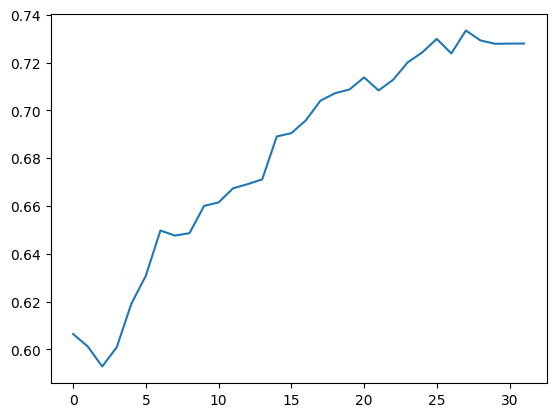